# Ideas for beta cooling schedule

In [1]:
import numpy as np
from regressor import LinearRegressor

from inversion_ideas import (
    ChiTarget,
    ConjugateGradient,
    DataMisfit,
    Inversion,
    MultiplierCooler,
    TikhonovZero,
)

## Create a true model and synthetic data for a linear regressor

In [2]:
n_params = 10
rng = np.random.default_rng(seed=4242)
true_model = rng.uniform(size=10)
true_model

array([0.78225148, 0.67148671, 0.2373809 , 0.17946133, 0.34662367,
       0.15210999, 0.31142952, 0.23900652, 0.54355731, 0.91770851])

In [3]:
# Build the X array
n_data = 25
shape = (n_data, n_params)
X = rng.uniform(size=n_data * n_params).reshape(shape)

In [4]:
synthetic_data = X @ true_model
maxabs = np.max(np.abs(synthetic_data))
noise = rng.normal(scale=1e-2 * maxabs, size=synthetic_data.size)
synthetic_data += noise
synthetic_data

array([2.83840696, 2.18091081, 2.00623242, 2.08333039, 2.01694883,
       2.7826232 , 2.10564027, 1.27333506, 2.08859855, 1.94177648,
       1.88492037, 2.92394733, 2.17231952, 3.08009275, 1.61670886,
       1.77403753, 2.67305005, 1.91413882, 2.42117827, 2.13991628,
       2.0153805 , 2.71388471, 2.65944255, 2.44416121, 3.14217523])

## Define data misfit and smallness

In [5]:
uncertainty = 1e-2 * maxabs * np.ones_like(synthetic_data)
simulation = LinearRegressor(X)
data_misfit = DataMisfit(synthetic_data, uncertainty, simulation)

In [6]:
smallness = TikhonovZero(n_params)

## Solution with fixed beta

In [7]:
phi_fixed = data_misfit + 1e-3 * smallness
initial_model = np.zeros(n_params)
minimizer = ConjugateGradient()
inverted_model = minimizer(phi_fixed, initial_model)
inverted_model

array([0.81328886, 0.65927514, 0.2472937 , 0.19624752, 0.3237346 ,
       0.14720342, 0.3194468 , 0.25235983, 0.52215485, 0.92181018])

In [8]:
print("Result:")
print(inverted_model)
print()
print("True model:")
print(true_model)

Result:
[0.81328886 0.65927514 0.2472937  0.19624752 0.3237346  0.14720342
 0.3194468  0.25235983 0.52215485 0.92181018]

True model:
[0.78225148 0.67148671 0.2373809  0.17946133 0.34662367 0.15210999
 0.31142952 0.23900652 0.54355731 0.91770851]


## Apply beta cooling schedule (manually)

In [9]:
minimizer = ConjugateGradient()

In [10]:
n_iters = 10
beta_cooling_factor = 5
initial_model = np.zeros(n_params)
model = initial_model.copy()

# Initialize objective function
beta_0 = 1e2
regularization = beta_0 * smallness
phi = data_misfit + regularization

# Print initial values
dmisfit_value = data_misfit(model)
print(" i  |  beta      | data misfit")
print("------------------------------")

i = 1
while True:
    # Minimize
    model = minimizer(phi, model)
    dmisfit_value = data_misfit(model)
    # Log
    print(f"{i:2d}  |  {regularization.multiplier:.2e}  |  {dmisfit_value:.2e}")
    # Stopping criteria
    if i == n_iters:
        break
    i += 1
    # Cool
    regularization.multiplier /= beta_cooling_factor

print(model)

 i  |  beta      | data misfit
------------------------------
 1  |  1.00e+02  |  1.46e+01
 2  |  2.00e+01  |  1.18e+01
 3  |  4.00e+00  |  1.17e+01
 4  |  8.00e-01  |  1.17e+01
 5  |  1.60e-01  |  1.17e+01
 6  |  3.20e-02  |  1.17e+01
 7  |  6.40e-03  |  1.17e+01
 8  |  1.28e-03  |  1.17e+01
 9  |  2.56e-04  |  1.17e+01
10  |  5.12e-05  |  1.17e+01
[0.81326156 0.65925428 0.24726515 0.19626779 0.32373014 0.14719275
 0.31947376 0.25235055 0.52216834 0.92184173]


## Use classes

In [11]:
# Objective function
beta_0 = 1e4
regularization = beta_0 * smallness
phi = data_misfit + regularization

# Initial model
initial_model = np.zeros(n_params)

# Minimizer
minimizer = ConjugateGradient()

# Directives
cooler = MultiplierCooler(cooling_factor=2.0)

# Stopping criteria
stopping_criteria = ChiTarget(data_misfit, chi_target=1.0)

inversion = Inversion(
    phi,
    initial_model,
    minimizer,
    stopping_criteria=stopping_criteria,
)

TypeError: MultiplierCooler.__init__() missing 1 required positional argument: 'scaled_objective'

In [12]:
phi_d, phi_m = [], []

In [13]:
for model in inversion:
    dmisfit_i, phi_m_i = data_misfit(model), regularization.function(model)
    phi_d.append(dmisfit_i)
    phi_m.append(phi_m_i)

    # Compute chi factor
    chi = dmisfit_i / data_misfit.n_data

    row = [
        f"{inversion.counter:2d}",
        f"{regularization.multiplier:.2e}",
        f"{model[0]:.2e}",
        f"{chi:.2e}",
    ]
    print(" | ".join(row))

    # Cool down beta
    cooler(regularization)

print(model)

NameError: name 'inversion' is not defined

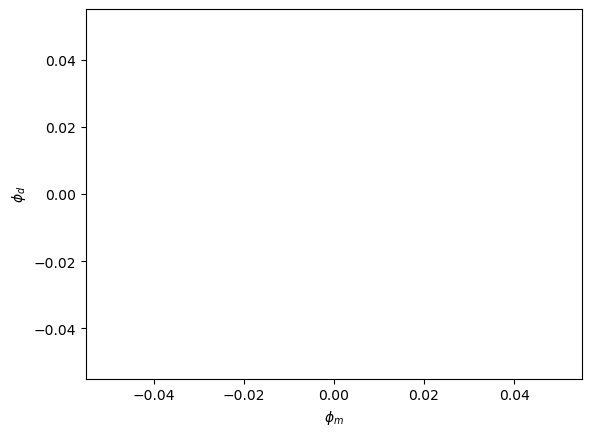

In [14]:
import matplotlib.pyplot as plt

plt.plot(phi_m, phi_d, "o-")
plt.xlabel(r"$\phi_m$")
plt.ylabel(r"$\phi_d$")
plt.show()

In [15]:
true_model

array([0.78225148, 0.67148671, 0.2373809 , 0.17946133, 0.34662367,
       0.15210999, 0.31142952, 0.23900652, 0.54355731, 0.91770851])

In [16]:
model

array([0.81326156, 0.65925428, 0.24726515, 0.19626779, 0.32373014,
       0.14719275, 0.31947376, 0.25235055, 0.52216834, 0.92184173])